# Piloting 02: Descriptive Analysis

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Section 1: Load and prepare data

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = read_csv(os.path.join('data','data.csv'))

## Reject participants.
reject = read_csv(os.path.join('data','reject.csv'))
data = data.merge(reject[['Subject','Reject']]).query('Reject==False')

## Section 2: Plot Accuracy by Exposure

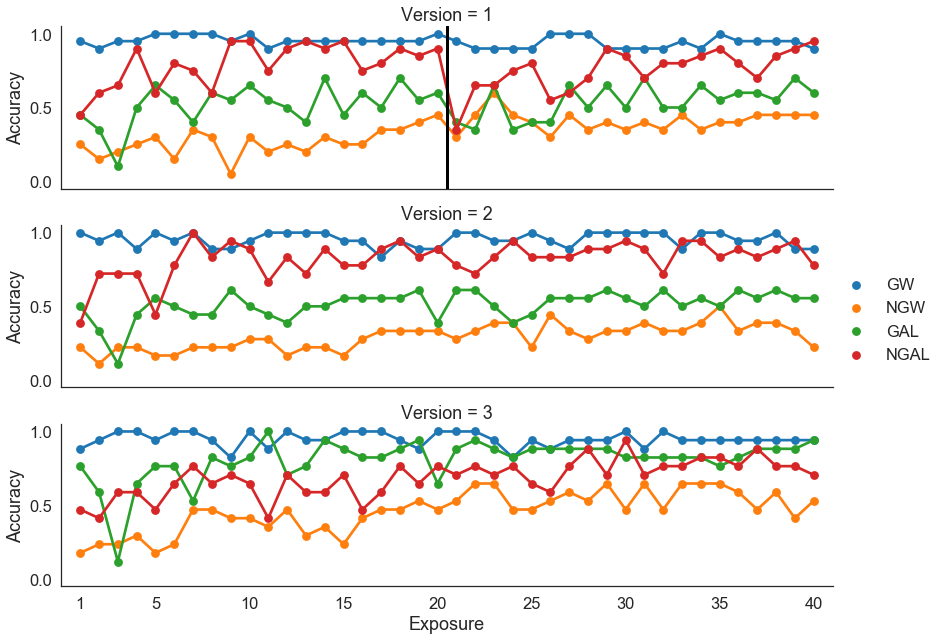

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
g = sns.FacetGrid(data, row='Version', height=3, aspect=4)
xticks = np.array([0,4,9,14,19,24,29,34,39])
palette = sns.color_palette(n_colors=4)

## Plot accuracy.
g.map(sns.pointplot, 'Exposure', 'Accuracy', 'Robot', order=np.arange(40)+1,
      hue_order=['GW','NGW','GAL','NGAL'], palette=palette, ci=None)
g.set(xticks=xticks, xticklabels=xticks+1, xlim=(-1,40), ylim=(-0.05,1.05))
g.axes[0,0].axvline(19.5,color='k',lw=3,zorder=10);
g.add_legend()

sns.despine()

## Section 3: Plot Accuracy by Participant

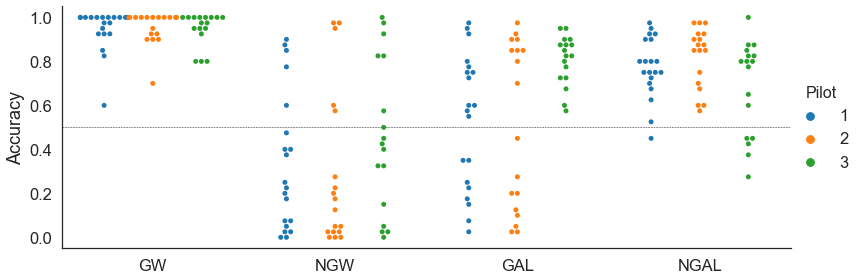

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute accuracy per version/subject/robot.
gb = data.groupby(['Version','Subject','Robot']).Accuracy.mean().reset_index()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
palette = sns.color_palette(n_colors=4)

## Plot accuracy.
sns.swarmplot('Robot', 'Accuracy', 'Version', data=gb, order=['GW','NGW','GAL','NGAL'], dodge=True)
ax.axhline(0.50, color='0.1', lw=0.5, linestyle='--')
legend = ax.legend(loc=7, bbox_to_anchor=(1.1,0.5), frameon=False, title='Pilot')
plt.setp(legend.get_title(),fontsize=16)
ax.set(xlabel='', ylim=(-0.05,1.05))

sns.despine()
plt.tight_layout()

## Section 4: Plot Accuracy Trajectories

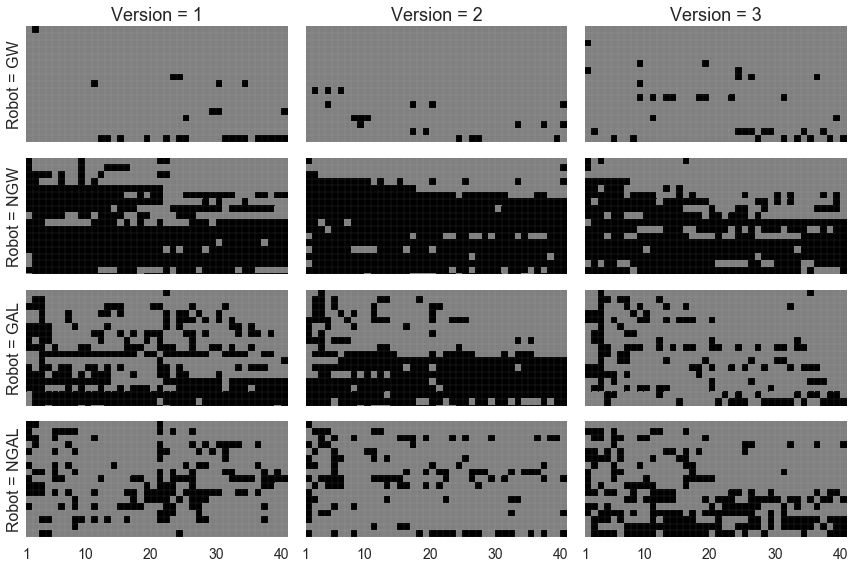

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct pivot table.
pivot = data.pivot_table('Accuracy',('Robot','Version','Subject'),'Exposure')

## Define sort indices.
ix = [np.argsort(data.query(f'Version=={v}').groupby('Subject').Accuracy.mean().values)[::-1]
      for v in [1,2,3]]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(4,3,figsize=(12,8),sharex=True,sharey=True)
row_order = ['GW','NGW','GAL','NGAL']
col_order = [1,2,3]
xticks = np.insert(np.arange(9,40,10),0,0)

## Iteratively plot.
for i, row in enumerate(row_order):
    
    for j, col in enumerate(col_order):
        
        ## Extract values.
        arr = pivot.loc[row,col].values[ix[j]]
        n,m = arr.shape
        
        ## Plot heatmap.
        sns.heatmap(arr, vmin=0, vmax=1, center=0.5, cmap=['0.0','0.5'], cbar=False,
                    xticklabels=[], yticklabels=[], ax=axes[i,j])
        
        ## Add gridlines.
        axes[i,j].hlines(np.arange(1,n),0,m,color='w',alpha=0.05)
        axes[i,j].vlines(np.arange(1,m),0,n,color='w',alpha=0.05)  
        
        ## Add details.
        axes[i,j].set(xlabel='', ylabel='')
        if not i: axes[i,j].set_title(f'Version = {col}')
        if not j: axes[i,j].set_ylabel(f'Robot = {row}', fontsize=16)
        if i == 3: axes[i,j].set_xticks(xticks); axes[i,j].set_xticklabels(xticks+1, fontsize=14)
            
plt.tight_layout()

## Section 5: Sensitivity to Sham Feedback by Participant

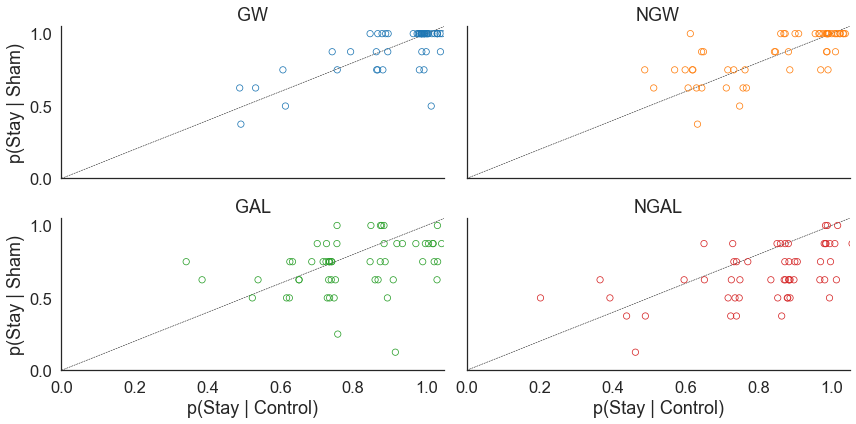

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define previous sham.
data['PrevSham'] = data.groupby(['Subject','Robot']).Sham.transform(lambda x: np.roll(x,1))

## Define stay trials.
f = lambda arr: (arr == np.roll(arr, 1)).astype(int)
data['Stay'] = data.groupby(['Subject','Robot']).Choice.transform(f)

## Compute p(Stay) by sham/control trials.
gb = data.query('Sham==1 or PrevSham==1').query('Exposure > 1 and Exposure < 40')
control = data.groupby(['Robot','Version','Subject','Sham']).Stay.mean().reset_index()
prevsham = data.groupby(['Robot','Version','Subject','PrevSham']).Stay.mean().reset_index()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Initialize canvas.
fig, axes = plt.subplots(2,2,figsize=(12,6),sharex=True,sharey=True)
robots = ['GW','NGW','GAL','NGAL']
palette = sns.color_palette(n_colors=4)

for ax, robot, color in zip(axes.flatten(), robots, palette):

    ## Extract x/y.
    x = control.query(f'Sham==1 and Robot=="{robot}"').Stay.values
    y = prevsham.query(f'PrevSham==1 and Robot=="{robot}"').Stay.values
    x_jitter = np.random.normal(0,0.02,x.size)
    
    ## Plot stay probabilities.
    ax = sns.scatterplot(x+x_jitter, y, color=color, s=40, facecolor='none', edgecolor=color, ax=ax)
    ax.plot([0,1.05],[0,1.05],color='k',lw=0.5,linestyle='--',zorder=-1)

    ## Add details.
    ax.set(xlim=(0,1.05), ylim=(0,1.05), title=robot)
    if 'AL' in robot: ax.set_xlabel('p(Stay | Control)') 
    if not 'N' in robot: ax.set_ylabel('p(Stay | Sham)') 

sns.despine()
plt.tight_layout()